In [1]:
import cv2

import numpy as np;
import tifffile
import os
import matplotlib.pyplot as plt
import copy
%load_ext autoreload
%autoreload 2

In [2]:
# From: https://stackoverflow.com/questions/8076889/how-to-use-opencv-simpleblobdetector

# Get images with segmentation

which_slice = 13
alpha = 0.15

f = lambda tif : (alpha*tif.asarray()[which_slice]).astype('uint8')

dat_foldername = r'..\point_cloud_alignment'

vol0 = os.path.join(dat_foldername, 'img100.tif')
with tifffile.TiffFile(vol0) as tif:
    im1_raw = f(tif)

vol1 = os.path.join(dat_foldername, 'img101.tif')
with tifffile.TiffFile(vol1) as tif:
    im2_raw = f(tif)

## Blob detector

In [23]:
from DLC_for_WBFM.utils.feature_detection.utils_detection import detect_blobs


In [25]:
keypoints, _ = detect_blobs(im1_raw)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures
# the size of the circle corresponds to the size of blob
im1 = cv2.GaussianBlur(im1_raw,(3,3),0)

im_with_keypoints = cv2.drawKeypoints(im1, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show blobs
#cv2.imshow("Keypoints", im_with_keypoints)

Text(0.5, 1.0, 'Found 22 keypoints')

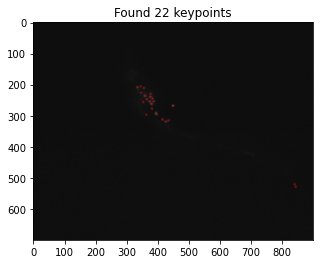

In [26]:
%matplotlib inline
plt.imshow(im_with_keypoints)
plt.title(f"Found {len(keypoints)} keypoints")

## 3d blob detection

In [27]:
from ipywidgets import interact
import open3d as o3d
from DLC_for_WBFM.utils.feature_detection.utils_features import build_feature_tree
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import visualize_cluster_labels
import pandas as pd

In [28]:
alpha = 0.15

f = lambda dat, which_slice : (alpha*dat[which_slice]).astype('uint8')

dat_foldername = r'..\point_cloud_alignment'

vol0 = os.path.join(dat_foldername, 'img100.tif')


num_slices = 33
with tifffile.TiffFile(vol0) as tif:
    dat = tif.asarray()

## Try to track via ICP on planes

In [36]:
from DLC_for_WBFM.utils.feature_detection.utils_detection import build_point_clouds_for_volume, build_correspondence_icp


In [37]:
# Build point clouds for each plane

all_keypoints_pcs = build_point_clouds_for_volume(dat,
                                                  num_slices,
                                                  alpha)

In [39]:
all_icp = build_correspondence_icp(all_keypoints_pcs)

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


## Build tracklets from the above matches

In [10]:
# From: http://www.open3d.org/docs/release/tutorial/pipelines/icp_registration.html
import copy
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import visualize_tracks_simple

def draw_registration_result(source, target, transformation, base=None):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([0, 1, 0])
    target_temp.paint_uniform_color([1, 0, 0])
    
    source_temp.transform(transformation)
    if base is not None:
        o3d.visualization.draw_geometries([base, source_temp, target_temp])
    else:
        o3d.visualization.draw_geometries([source_temp, target_temp])

In [11]:
full_pc = o3d.geometry.PointCloud()
for pc in all_keypoints_pcs:
#     pc.paint_uniform_color(np.random.rand(3,1))
#     print(len(pc.points))
    full_pc = full_pc + pc
full_pc.paint_uniform_color([0.5,0.5,0.5])

PointCloud with 1133 points.

In [12]:
# vis = o3d.visualization.Visualizer()
# vis.create_window()
# vis.add_geometry(full_pc)
# vis.get_render_option()
# vis.run()
# vis.destroy_window()

In [13]:
verbose = 1

# Use registration results to build a combined and colored pointcloud
# pc_ind_to_cluster = []
clust_df = pd.DataFrame(columns=['clust_ind', 'all_ind_local', 'all_ind_global','slice_ind','to_be_finished', 'not_finished'])#,
#                       dtype=object)


def create_new_track(i0, i1, next_clust_ind, clust_df,
                    this_point_cloud_offset,
                    next_point_cloud_offset,
                    which_slice):
    
    new_track = pd.DataFrame({'clust_ind':next_clust_ind, 
                              'all_ind_local':[[i0,i1]], 
                              'all_ind_global':[[this_point_cloud_offset+i0, i1_global]],
                              'slice_ind':[[which_slice, which_slice+1]],
                              'to_be_finished':False, 
                              'not_finished':True})
    clust_df = clust_df.append(new_track, ignore_index=True)
    print(f"Creating new track {next_clust_ind}")
    next_clust_ind = next_clust_ind + 1
    
    return next_clust_ind, clust_df


def extend_track(i1, i1_global, row, i, clust_df, which_slice):
    row['all_ind_local'].append(i1)
#     print("current local ind", row['all_ind_local'])
    clust_df.at[i,'all_ind_local'] = list(row['all_ind_local'])
    row['all_ind_global'].append(i1_global)
    clust_df.at[i,'all_ind_global'] = list(row['all_ind_global'])
    row['slice_ind'].append(which_slice+1)
    clust_df.at[i,'slice_ind'] = list(row['slice_ind'])
    clust_df.at[i,'to_be_finished'] = False
    
    clust_ind = row['clust_ind']
    tmp = len(row['all_ind_local'])
    print(f"Adding to track {clust_ind} (length {tmp})")
    
    return clust_df

ongoing_tracks = {}
next_clust_ind = 0

this_point_cloud_offset = 0
next_point_cloud_offset = 0

for i_match, reg in enumerate(all_icp):
#     print(f"{i} / {num_slices}")
    # Get transform to global coordinates
    this_pc = all_keypoints_pcs[i_match]
    next_pc = all_keypoints_pcs[i_match+1]
    next_point_cloud_offset = next_point_cloud_offset + len(this_pc.points)
    
    offsets = {'next_point_cloud_offset':next_point_cloud_offset,
               'this_point_cloud_offset':this_point_cloud_offset,
              'which_slice':i_match}
    
    pairs = np.asarray(reg.correspondence_set)
    # Initialize ALL as to-be-finished
    clust_df['to_be_finished'] = True
    
    for i0, i1 in pairs:
#         print(clust_df)
        i1_global = next_point_cloud_offset+i1
        # If no tracks, need special logic
        ind_to_check = clust_df['not_finished']
        if len(ind_to_check)==0:
            next_clust_ind, clust_df = create_new_track(i0, i1, next_clust_ind, clust_df, **offsets)
            continue
        # Add to previous track if possible
        for i, row in clust_df[ind_to_check].iterrows():
#             print(f"pair: {i0}, {i1}, trying cluster: {i}")
            if i0 == row['all_ind_local'][-1]:
                clust_df = extend_track(i1, i1_global, row, i, clust_df,i_match)
                break
        else:
            # Create new track
#             if i_match>1:
#                 error
            next_clust_ind, clust_df = create_new_track(i0, i1, next_clust_ind, clust_df, **offsets)
        
    # Finalize tracks that didn't get a new point this loop
    to_finish = clust_df['to_be_finished']
    if len(np.where(to_finish)[0]) > 0 and verbose >= 1:
        print(f"Finished tracks {np.where(to_finish)[0]}")
    clust_df.loc[to_finish,'not_finished'] = False
    
    if verbose >= 2 and len(pairs) > 0:
#         draw_registration_result(this_pc, next_pc, reg.transformation, base=None)
        visualize_tracks_simple(this_pc, next_pc, pairs)
    
    this_point_cloud_offset = next_point_cloud_offset
    
        

Creating new track 0
Adding to track 0 (length 3)
Adding to track 0 (length 4)
Adding to track 0 (length 5)
Creating new track 1
Adding to track 0 (length 6)
Adding to track 1 (length 3)
Creating new track 2
Creating new track 3
Adding to track 0 (length 7)
Adding to track 3 (length 3)
Adding to track 0 (length 8)
Adding to track 2 (length 3)
Adding to track 1 (length 4)
Adding to track 0 (length 9)
Creating new track 4
Creating new track 5
Adding to track 2 (length 4)
Adding to track 1 (length 5)
Creating new track 6
Adding to track 5 (length 3)
Adding to track 1 (length 6)
Adding to track 4 (length 3)
Creating new track 7
Finished tracks [3]
Adding to track 6 (length 3)
Creating new track 8
Adding to track 4 (length 4)
Creating new track 9
Adding to track 5 (length 4)
Creating new track 10
Creating new track 11
Creating new track 12
Adding to track 6 (length 4)
Adding to track 8 (length 3)
Creating new track 13
Creating new track 14
Adding to track 9 (length 3)
Creating new track 15


Adding to track 8 (length 15)
Adding to track 70 (length 5)
Adding to track 65 (length 4)
Creating new track 90
Adding to track 75 (length 4)
Finished tracks [ 0  1  2  3  5  6  7  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 46 48 49 50 51 52 53
 54 56 62 63 64 66 67 69 72 73 77]
Creating new track 91
Adding to track 55 (length 5)
Adding to track 87 (length 3)
Creating new track 92
Adding to track 70 (length 6)
Adding to track 59 (length 6)
Creating new track 93
Adding to track 82 (length 4)
Adding to track 68 (length 4)
Adding to track 89 (length 3)
Adding to track 87 (length 4)
Adding to track 70 (length 7)
Adding to track 88 (length 3)
Adding to track 92 (length 3)
Creating new track 94
Adding to track 76 (length 4)
Creating new track 95
Adding to track 84 (length 3)
Adding to track 79 (length 3)
Creating new track 96
Adding to track 60 (length 7)
Adding to track 84 (length 4)
Creating new track 97
Adding to track 4 (length 1

Adding to track 122 (length 5)
Adding to track 126 (length 4)
Adding to track 127 (length 3)
Creating new track 146
Adding to track 120 (length 4)
Adding to track 88 (length 10)
Creating new track 147
Adding to track 70 (length 17)
Creating new track 148
Adding to track 93 (length 10)
Adding to track 132 (length 3)
Adding to track 118 (length 4)
Adding to track 123 (length 4)
Creating new track 149
Adding to track 76 (length 13)
Adding to track 88 (length 11)
Adding to track 104 (length 7)
Adding to track 95 (length 11)
Creating new track 150
Adding to track 45 (length 14)
Adding to track 119 (length 5)
Finished tracks [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  61  62  63  64  65  66  67  69  71  72  73  74  75
  77  78  79  80  81  82  83  84  85  86  87  89  90  91  92  96  97  98
  99 100

Adding to track 154 (length 6)
Adding to track 149 (length 6)
Creating new track 191
Creating new track 192
Adding to track 155 (length 7)
Adding to track 110 (length 12)
Adding to track 147 (length 6)
Adding to track 70 (length 23)
Adding to track 109 (length 13)
Creating new track 193
Adding to track 178 (length 5)
Adding to track 94 (length 16)
Adding to track 70 (length 24)
Adding to track 161 (length 6)
Adding to track 104 (length 11)
Adding to track 138 (length 11)
Adding to track 179 (length 3)
Adding to track 160 (length 4)
Adding to track 152 (length 6)
Adding to track 158 (length 6)
Adding to track 122 (length 10)
Adding to track 174 (length 3)
Adding to track 127 (length 8)
Finished tracks [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  71  7

## Visualize the tracklets 1: by cluster

In [14]:
# Assign colors to the data frame based on cluster id
max_label = clust_df['clust_ind'].max()
clust_df['colors'] = list(plt.get_cmap("tab20")(pd.to_numeric(clust_df.clust_ind, downcast='float') / max_label))
# clust_df['colors'] = list(plt.get_cmap()(pd.to_numeric(clust_df.clust_ind, downcast='float') / max_label))

# Add colors to actual point cloud
full_pc.paint_uniform_color([0,0,0])
final_colors = np.asarray(full_pc.colors)

for i, row in clust_df.iterrows():
    these_ind = row.all_ind_global
    if len(these_ind) < 3:
        continue
    this_color = row['colors']
    print(f"Color {this_color[:3]} for neurons {these_ind}")
    
    all_colors = np.vstack([this_color[:3] for i in these_ind])
    final_colors[these_ind,:] = all_colors

full_pc.colors = o3d.utility.Vector3dVector(final_colors)

Color [0.12156863 0.46666667 0.70588235] for neurons [68, 69, 70, 71, 72, 74, 78, 82, 115]
Color [0.12156863 0.46666667 0.70588235] for neurons [73, 76, 80, 85, 93, 92, 118, 121, 178, 226]
Color [0.12156863 0.46666667 0.70588235] for neurons [77, 81, 84, 94]
Color [0.12156863 0.46666667 0.70588235] for neurons [75, 79, 83]
Color [0.12156863 0.46666667 0.70588235] for neurons [90, 101, 113, 143, 177, 207, 222, 270, 307, 354, 422, 480, 465, 498, 489, 529, 536, 544]
Color [0.12156863 0.46666667 0.70588235] for neurons [87, 96, 95, 117, 116, 150, 192, 259, 320, 378]
Color [0.12156863 0.46666667 0.70588235] for neurons [88, 103, 123, 126, 159, 208, 252, 300, 303]
Color [0.12156863 0.46666667 0.70588235] for neurons [89, 98, 120, 154, 194, 191, 232, 279, 332, 344, 418]
Color [0.12156863 0.46666667 0.70588235] for neurons [108, 134, 132, 165, 216, 275, 278, 306, 342, 359, 365, 427, 415, 408, 456, 509]
Color [0.12156863 0.46666667 0.70588235] for neurons [109, 135, 136, 160, 200, 196, 240, 299

In [15]:
o3d.visualization.draw_geometries([full_pc])

In [16]:
full_pc.paint_uniform_color([0,0,0])
# o3d.visualization.draw_geometries([full_pc])
# Add colors to actual point cloud
full_pc.paint_uniform_color([0,0,0])
final_colors = np.asarray(full_pc.colors)

# these_ind = range(0,67) # First layer
# these_ind = [68, 69, 70, 71, 72, 74, 78, 82, 115] # A clean neuron
these_ind = clust_df['all_ind_global'][1]
this_color = [0,1,0,1]
print(f"Color {this_color[:3]} for neurons {these_ind}")

all_colors = np.vstack([this_color[:3] for i in these_ind])
final_colors[these_ind,:] = all_colors

full_pc.colors = o3d.utility.Vector3dVector(final_colors)

o3d.visualization.draw_geometries([full_pc])

Color [0, 1, 0] for neurons [73, 76, 80, 85, 93, 92, 118, 121, 178, 226]


## Visualize the tracklets 2: using connecting lines

In [17]:
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *

In [18]:
all_matches = [np.array(icp.correspondence_set) for icp in all_icp]
all_pc = copy.copy(all_keypoints_pcs)

In [19]:
# error

In [20]:
visualize_tracks_multiple_matches(all_pc, all_matches)

In [21]:
line = build_line_set_from_matches(all_pc[0], all_pc[1], all_matches[0])

In [22]:
error

NameError: name 'error' is not defined

## Align the volume before blob identification

In [ ]:

from DLC_for_WBFM.utils.feature_detection.utils_features import *
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *

In [ ]:
def align_pair_of_images(im1, im2, use_skimage=True):
    """
    Aligns two images using orb-generated features
    
    Args:
        im1: numpy image in XY or XYC (color optional)
        
        im2: same format as im1
    """
    
    # Convert images to grayscale
    im1Gray, im2Gray = convert_to_grayscale(im1, im2)

    # Features
    keypoints1, keypoints2, matches = detect_features_and_match(im1, im1Gray, im2, im2Gray)

    # Extract location of good matches
    points1, points2 = extract_location_of_matches(matches, keypoints1, keypoints2)

    # Find homography
#     h, mask = cv2.estimateAffine2D(points1, points2)
    if use_skimage:
        h = transform.estimate_transform('euclidean', points1, points2)
    else:
        h, mask = cv2.estimateAffinePartial2D(points1, points2)

    # Use homography
    # Only width and height, removing color channels if any
    if use_skimage:
        im1Reg = transform.warp(im1, inverse_map=h.inverse) 
#         im1Reg = None
    else:
        im1Reg = cv2.warpAffine(im1, h, im2.shape[:2])

    return im1Reg, h, keypoints1, keypoints2, matches

# ===============================================================================
# OLD

### Alternate clustering tests

In [ ]:
# def remove_outliers_from_2_clouds(this_pc, next_pc):
#     combined_pc = this_pc + next_pc
#     if len(this_pc.points) > 0 and len(next_pc.points) > 0:   
#         cl, ind = combined_pc.remove_radius_outlier(nb_points=1, radius=3.0)

#         cut = len(this_pc.points)
#         print(ind)

#         out1 = this_pc.select_by_index(ind[:cut])
#         out2 = next_pc.select_by_index(ind[cut:])
#     else:
#         print("Empty point cloud; removing no outliers")
    
#     return out1, out2

In [ ]:
# Build correspondence between each pair of planes
# import copy

# all_icp = []
# opt = {'max_correspondence_distance':10.0}

# for i in range(10, num_slices-1):
# #     print(f"{i} / {num_slices}")
# #     this_pc = 
# #     next_pc = 
    
#     this_pc, next_pc = remove_outliers_from_2_clouds(copy.deepcopy(all_keypoints_pcs[i]), copy.deepcopy(all_keypoints_pcs[i+1]))
    
#     reg = o3d.pipelines.registration.registration_icp(this_pc, next_pc, **opt)
    
#     all_icp.append(reg)

In [ ]:
# # Try correspondence via global registration, not ICP

# all_icp = []
# feature_opt = {'search_param':o3d.geometry.KDTreeSearchParamHybrid(radius=50.0, max_nn=10)}

# for i in range(10, num_slices-1):
# #     print(f"{i} / {num_slices}")
#     this_pc = all_keypoints_pcs[i]
#     next_pc = all_keypoints_pcs[i+1]
    
#     # Generate features
#     f1 = o3d.pipelines.registration.compute_fpfh_feature(this_pc, **feature_opt)
#     f2 = o3d.pipelines.registration.compute_fpfh_feature(next_pc, **feature_opt)
    
#     reg =  o3d.pipelines.registration.registration_ransac_based_on_feature_matching(this_pc, next_pc, f1, f2)
    
#     all_icp.append(reg)

## Simplest: find peaks

In [ ]:
from skimage.feature import peak_local_max

In [ ]:
# Background subtraction:
# https://docs.opencv.org/3.3.0/db/d5c/tutorial_py_bg_subtraction.html
# Peak detection:
# https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_peak_local_max.html

#im1 = np.abs(cv2.GaussianBlur(im1_raw,(3,3),0) - np.min(im1_raw))
im1 = cv2.GaussianBlur(im1_raw,(3,3),0)
fgbg = cv2.createBackgroundSubtractorKNN()
fgbg.apply(im1)

%matplotlib notebook
plt.imshow(im1)

thresh = np.mean(im1)+10
coordinates = peak_local_max(im1, min_distance=5, num_peaks=200, threshold_abs=thresh)

In [ ]:

plt.imshow(im1, cmap=plt.cm.gray)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')

## Thresholds

In [ ]:
# Do some preprocessing
# From: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html
# Otsu's thresholding
im1 = cv2.GaussianBlur(im1_raw,(5,5),0)
#ret2,im1 = cv2.threshold(im1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
im1 = cv2.adaptiveThreshold(im1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

# Make neurons dark spts
#im1 = cv2.bitwise_not(im1)

In [ ]:
%matplotlib inline
plt.imshow(im1)

## Contours

In [ ]:
# Just find contours
%matplotlib inline
contours, hierarchy = cv2.findContours(im1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

im = np.expand_dims(im1, axis=2).repeat(3, axis=2) 
for k, _ in enumerate(contours):
    im = cv2.drawContours(im, contours, k, (0, 230, 255), 6)
plt.imshow(im)

## Try to track via clustering

In [ ]:

all_keypoints = []
all_ims_with_kps = []
    
for i in range(num_slices):
#     print(f"{i} / {num_slices}")
    im1_raw = f(dat, i)
    kp, im1 = detect_blobs(im1_raw)
    # Add to make the format: ZXY
    kp_3d = np.array([np.hstack((i, row.pt)) for row in kp])
    all_keypoints.extend(kp_3d)
    
    im_with_keypoints = cv2.drawKeypoints(im1, kp, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    all_ims_with_kps.append(im_with_keypoints)

all_keypoints = np.array(all_keypoints)

In [ ]:
def my_plot(i): 
    plt.imshow(all_ims_with_kps[i])
    plt.title(f"{i}")

In [ ]:
interact(my_plot, i=(0,num_slices-1))

In [ ]:

def combine_2d_blobs(all_keypoints, min_z_detections=3):
    """
    Assumes that a real neuron will be detected on more than one plane, and combines them
    """
    
#     all_xyz = all_keypoints[:].pt
    n, point_cloud, tree = build_feature_tree(all_keypoints)
    
    return point_cloud

In [ ]:
pc = combine_2d_blobs(all_keypoints)

In [ ]:
#o3d.visualization.draw_geometries([pc])

In [ ]:
# from sklearn.cluster import SpectralClustering
# opt = {'n_neighbors':2,
#        'n_clusters':150}
# clusterer = SpectralClustering(**opt)

In [ ]:
# from sklearn.cluster import AgglomerativeClustering
# opt = {'distance_threshold':2.0,
#        'compute_full_tree':True,
#        'linkage':'single',
#        'n_clusters':None}
# clusterer = AgglomerativeClustering(**opt)

In [ ]:
from sklearn.cluster import OPTICS
opt = {'min_samples':2,
       'max_eps':3.0}
clusterer = OPTICS(**opt)

In [ ]:
labels = clusterer.fit_predict(pc.points)

In [ ]:
visualize_cluster_labels(labels, pc)

## Simple test: dbscan

In [ ]:
labels = np.array(pc.cluster_dbscan(eps=1.5, min_points=3))

In [ ]:
visualize_cluster_labels(labels, pc)